# Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-01-22 16:18:08.475077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download the dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True, cache_dir = './')
data_dir = pathlib.Path(data_dir)

In [3]:
print(data_dir)

datasets/flower_photos


# Count the data

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


# Explore the data

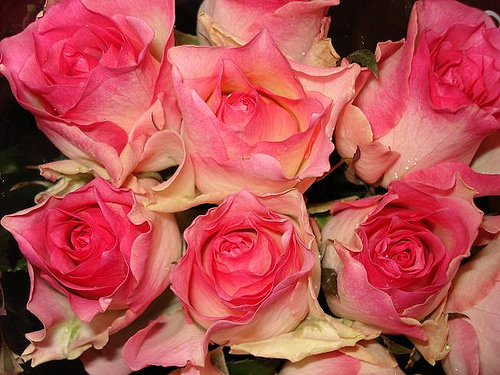

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

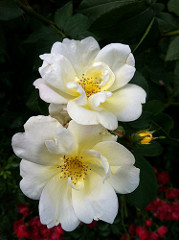

In [11]:
PIL.Image.open(str(roses[1]))

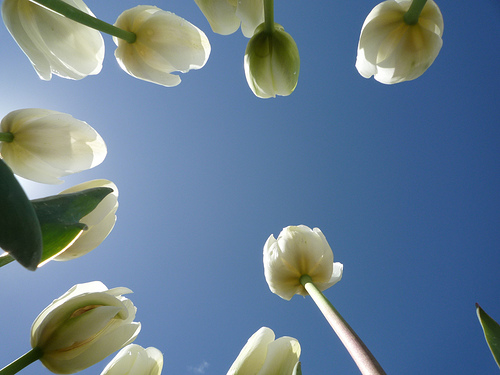

In [12]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

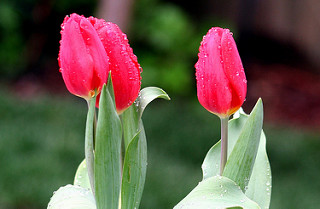

In [13]:
PIL.Image.open(str(tulips[1]))

# Create a dataset

### Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

# split the data

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-01-21 13:48:52.433298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


# Print class names

In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

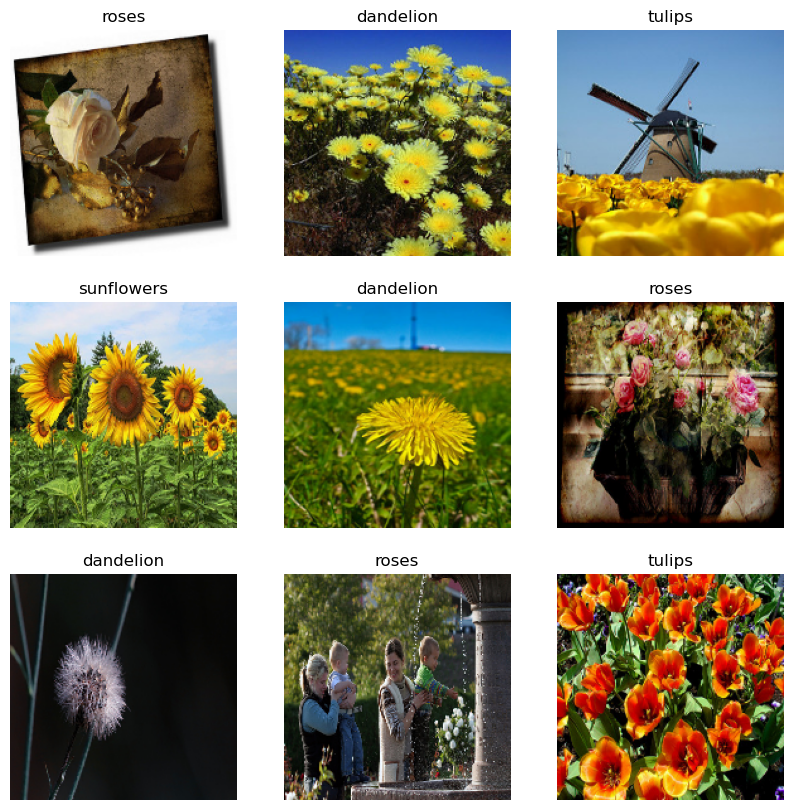

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Configure the dataset for performance

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

In [22]:
normalization_layer = layers.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-21 14:05:17.118338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 20 of 1000
2023-01-21 14:05:27.255255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 40 of 1000
2023-01-21 14:05:37.534327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 1000
2023-01-21 14:05:47.163395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 77 of 1000


0.0 1.0


2023-01-21 14:05:50.498668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


# Create the model

In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 47s 496ms/step - loss: 1.3612 - accuracy: 0.4346 - val_loss: 1.1137 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 34s 369ms/step - loss: 1.0144 - accuracy: 0.6046 - val_loss: 0.9818 - val_accuracy: 0.6063
Epoch 3/10
92/92 [==============================] - 34s 365ms/step - loss: 0.8118 - accuracy: 0.6952 - val_loss: 0.9188 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 33s 363ms/step - loss: 0.6055 - accuracy: 0.7813 - val_loss: 0.9805 - val_accuracy: 0.6594
Epoch 5/10
92/92 [==============================] - 34s 367ms/step - loss: 0.3964 - accuracy: 0.8587 - val_loss: 1.0820 - val_accuracy: 0.6390
Epoch 6/10
92/92 [==============================] - 33s 363ms/step - loss: 0.2380 - accuracy: 0.9220 - val_loss: 1.3544 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 33s 362ms/step - loss: 0.1509 - accuracy: 0.9537 - val_loss: 1.5966 - val_accuracy: 0.6240

# Visualizing the result

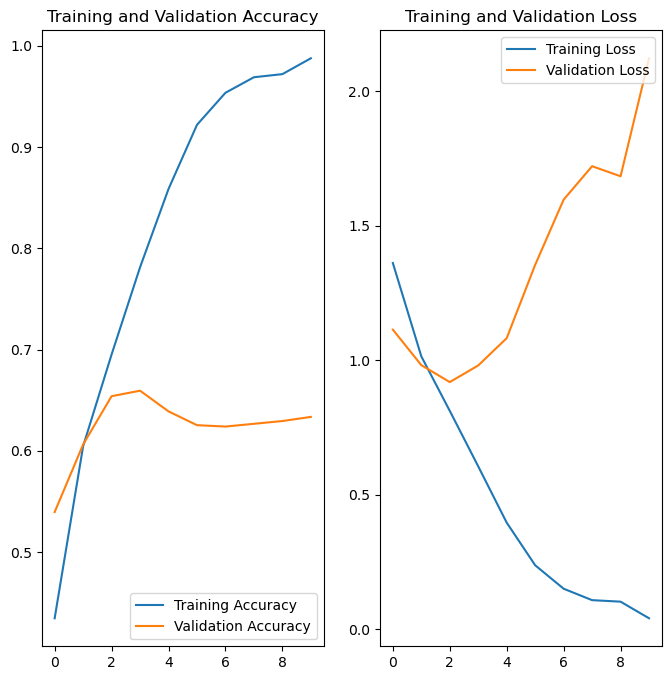

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

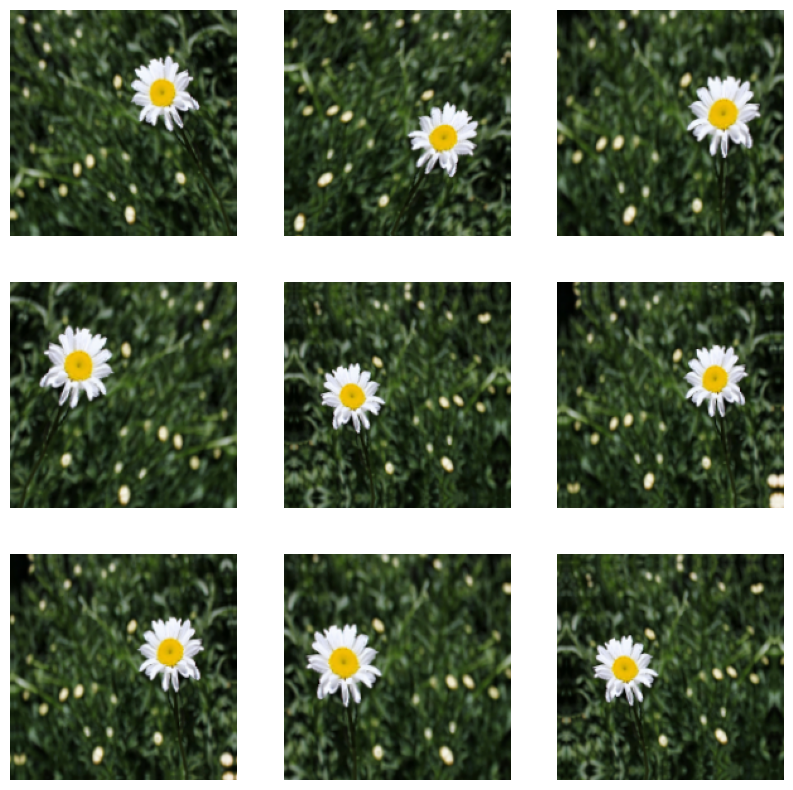

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Adding Dropout Layer

In [31]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile and Train the model

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 45s 435ms/step - loss: 1.2592 - accuracy: 0.4636 - val_loss: 1.0582 - val_accuracy: 0.5790
Epoch 2/15
92/92 [==============================] - 40s 430ms/step - loss: 1.0455 - accuracy: 0.5916 - val_loss: 0.9866 - val_accuracy: 0.6022
Epoch 3/15
92/92 [==============================] - 38s 417ms/step - loss: 0.9391 - accuracy: 0.6247 - val_loss: 1.0262 - val_accuracy: 0.5817
Epoch 4/15
92/92 [==============================] - 38s 416ms/step - loss: 0.8450 - accuracy: 0.6764 - val_loss: 0.8938 - val_accuracy: 0.6730
Epoch 5/15
92/92 [==============================] - 39s 424ms/step - loss: 0.8040 - accuracy: 0.6880 - val_loss: 0.8552 - val_accuracy: 0.6703
Epoch 6/15
92/92 [==============================] - 39s 422ms/step - loss: 0.7526 - accuracy: 0.7095 - val_loss: 0.8052 - val_accuracy: 0.6935
Epoch 7/15
92/92 [==============================] - 39s 424ms/step - loss: 0.6807 - accuracy: 0.7398 - val_loss: 0.7768 - val_accuracy: 0.6962

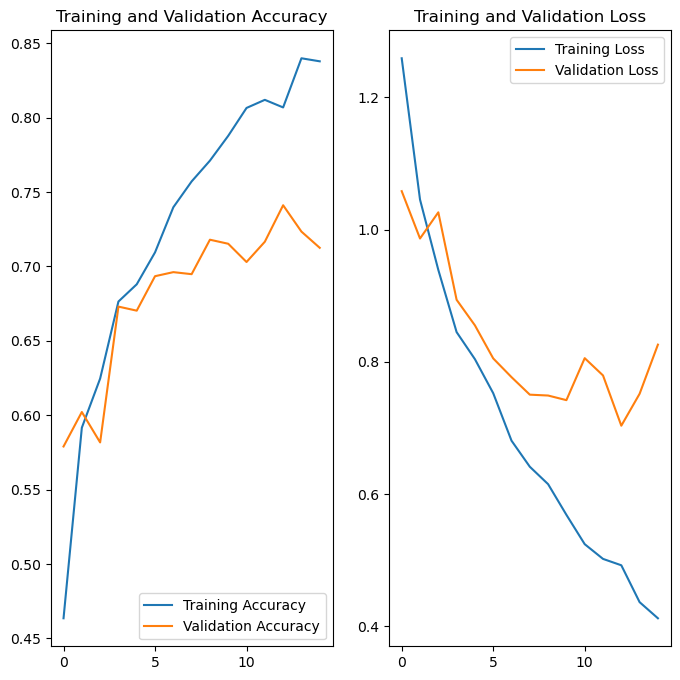

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url,cache_dir = './')

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)